In [55]:
# Third party
import importlib
import torch
import matplotlib.pyplot as plt

# User
import base.abstract
import base.mlp
import base.train
import base.encode
import base.pre_process
import model
import attention

importlib.reload(base.abstract)
importlib.reload(base.mlp)
importlib.reload(base.train)
importlib.reload(base.encode)
importlib.reload(base.pre_process)
importlib.reload(base.norm)
importlib.reload(model)
importlib.reload(attention)

from base.train import sgd
from base.encode import get_encoder_decoder
from base.mlp import LinearLayer, MLP
from base.train import sgd
from base.pre_process import get_dataset
from model import SimpleTransformer, Transformer
from attention import BatchedSelfAttentionHead
from encode import positional_encode

In [2]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))

In [3]:
token_length = 10
dataset =  get_dataset(text_encoded, token_length, context_window="expanding")
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)


(948085, 167309)

In [5]:
decoder(train_data[10].tolist()), train_data[10], train_targets[10]

('\nFirst Cit',
 tensor([ 0, 18, 47, 56, 57, 58,  1, 15, 47, 58]),
 tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]))

In [60]:
hp = {
    "init_learning_rate": .1,
    "converging_learning_rate": .01,
    "epochs": 100000,
    "dim_of_embedding": 12,
    "dim_of_attention_embedding": 12,
    "num_of_attention_heads": 3,
    "num_of_attention_blocks": 5,
    "num_layer_1_nodes": 10,
    "num_layer_2_nodes": 10,
    "mini_batch_size": 3,
    "token_length": token_length,
}

params = {
    "num_of_unique_chars": len(unique_chars),
    "positional_encoding_func": positional_encode,
    "attention_block_type": "decoder"
}

l1 = LinearLayer(
    num_of_inputs=hp['dim_of_attention_embedding'], #3x8x3 3x10 = 3x8x10
    num_of_neurons=hp["num_layer_1_nodes"],
    append_pre_activation_layer=True,
    activation_func=torch.tanh,
)
l2 = LinearLayer(
    num_of_inputs=hp["num_layer_2_nodes"],
    num_of_neurons=params["num_of_unique_chars"],
)

mlp_model = MLP(layers=[l1,l2])
attention_model = Transformer(hp, mlp_model, **params)


In [ ]:
attention_model.require_grad()
loss_list = []
sgd(hp
    , attention_model
    , training_inputs=train_data
    , training_targets=train_targets
    , loss_list=loss_list
)


epoch: 0 / 100000, loss: 7.5910
epoch: 10000 / 100000, loss: 3.0826
epoch: 20000 / 100000, loss: 3.2415
epoch: 30000 / 100000, loss: 2.4602
epoch: 40000 / 100000, loss: 2.9538
epoch: 50000 / 100000, loss: 2.6928
epoch: 60000 / 100000, loss: 2.5375
epoch: 70000 / 100000, loss: 2.7398
epoch: 80000 / 100000, loss: 2.5049


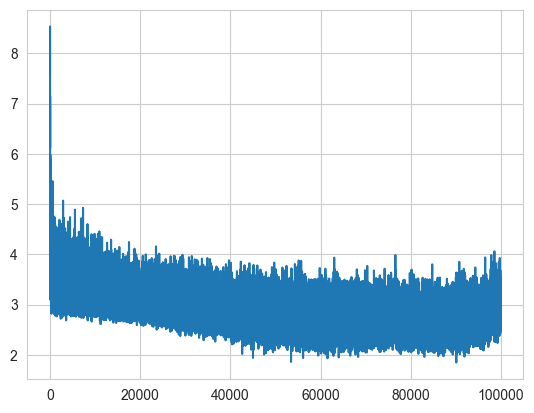

In [58]:
plt.plot(loss_list)


In [59]:
# Compute negative log likelihood of the train/validation

print(f"train loss: {attention_model.dataset_loss(train_data, train_targets)}")
print(f"validation loss: {attention_model.dataset_loss(validation_data, validation_targets)}" )

train loss: 2.950819379964145
validation loss: 2.9436191161422696


In [32]:
decoder(attention_model.generate(1000))

"BWy si m o se fou. co po o s his LIOIN:\n\nK:\nAn maden tes'd yeeye hyeshll frerspeearecipyh a meve irei houo no tho be\nMo h oud':\nC\nYod theinniintt s nin irs miYeathil lo s datheryeda tor. Jrers, hor wo sartt meard flal am thome, tol dig ward nedd ro mer, hes mhi fes bo\nAn j gen lo nofrteon t:or hy kan, ucy thete b.\nBFo than ve yenat LIO:\nBer wo inys o tiy?\nLutigr?ICoth is tin towd:\nethe yred fed, thor s the s hevide, thig, yoveaa hro mlolw bid ne ipota Psugos fa, bet:\nAthelit? hesad I uf.\n\nHTLANSNTEUfll Yisy s ses i nelo therntul acinI pexs righoroul mete,\nYo thange fo gir s ounelem\nH,\nLatrcutui thethleea s,\nFe mas fsomey\nLin\nANs\nC:\nAnw.\n\nO the brilisedodes leechy\nA: yousechhu hthen fe wod hop trit tou yougor as me fer, hefy;tcy,\nHn cho ye ongilererh fras, cyhit angeimetr mer bolaveas\nShek no s iBAMee bovinbise bicit;, o ard thr thom;the,\nGns art, pre. o,\nUTon'tsving ti I ros ig me' u s te acae'aces nir o thirundd.\n\nTowavr:\nO le! Oeing:\nEHnve to bese?\n

In [9]:
my_data = train_data[[306]]
characters =  decoder(my_data[0].tolist())
my_data, characters 

(tensor([[43, 58,  1, 59, 57,  1, 49, 47, 50, 50]]), 'et us kill')

In [129]:
torch.set_printoptions(sci_mode=False)
matrix = attention_model.inspect_attention(my_data)[1][0] # this is the weight matrix
matrix
#    F i r
# F  1 0 0
# i  0 1 0
# r  0 1 0

tensor([[    1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0044,     0.9956,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     1.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.8561,     0.0013,     0.0069,     0.1357,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0005,     0.0001,     0.0000,     0.0000,     0.9994,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.8056,     0.0002,     0.0000,     0.1942,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0288,     0.0049,     0.0000,     0.0009,     0.9495,     0.0000,
             0.0160,     0.0000,     0.0000,     0.0000],
        [    0.0334,     0.

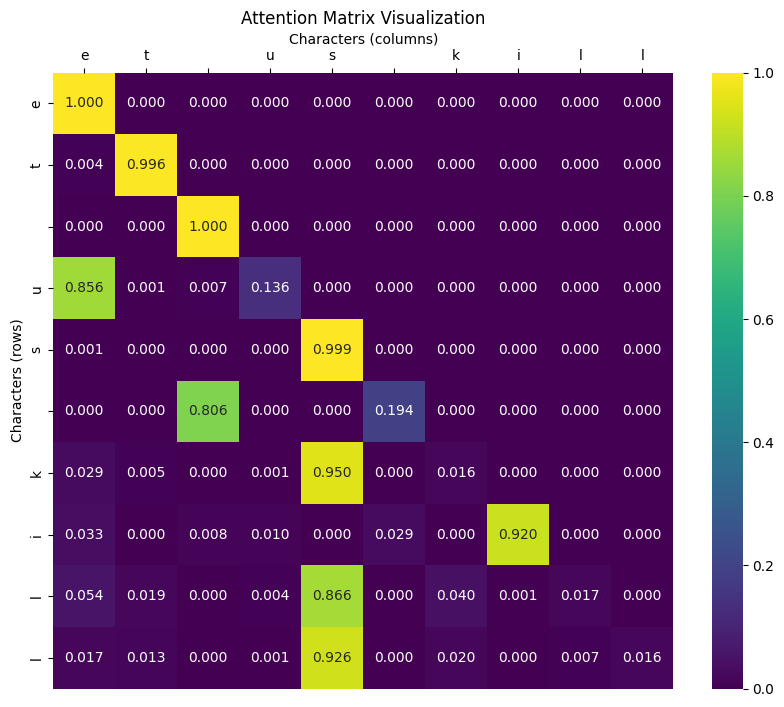

In [131]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(matrix.detach().numpy(), annot=True, cmap='viridis', xticklabels=characters, yticklabels=characters, fmt='.3f')

# Move the x-axis to the top and set its label position
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# You can add title and labels as needed
plt.title('Attention Matrix Visualization')
plt.xlabel('Characters (columns)')
plt.ylabel('Characters (rows)')

plt.show()